#  Introduction
In this blog post, I want to show you a nice complexity metric that is agnostic to the programming language you use for your software systems &ndash; the **indentation-based complexity** metric. Adam Tornhill describes this metric in his faboulous book [Software Design X-Rays](https://pragprog.com/book/atevol/software-design-x-rays) on page 25 as follows:
 
> With indentation-based complexity we count the leading tabs and whitespaces
to convert them into logical indentations. ... This works because indentations in code carry meaning. Indentations
are used to increase readability by separating code blocks from each other.

He further says that the development of the indentation-based complexity over time is in combination with the lines of code metric a good indicator for complexity-growth. If the lines of code doesn't change but the indentation does, you got a complexity problem in your code.

In this blog post, we are just interested in a static view of the indentation of a code. I want to show you how you can spot complex areas in your application by using the [Pandas data analysis framework](http://pandas.pydata.org/). As application, I choose the Linux kernel project because we want to apply our analysis at big scale. 

So let's start!

# The Idea

This analysis works as follows:

1. We search for relevant source code files using `glob`
1. We read in the source code by hacking Pandas' `read_csv()` method
1. We extract the preceding whitespaces / tabs in the code
1. We calculate the ratio between the lines of code of a file and the indentation complexity
1. We spot areas in the Linux kernel that are most complex

# Analysis
First, let's get all the files with a recursive file search by using `glob`. Because the Linux kernel code is mostly written in the C programming language, we search for the corresponding file endings `.c`  (C program code files) and `.h` (header files).

In [1]:
import glob
file_list = glob.glob("../../linux/**/*.[c|h]", recursive=True)
file_list[:5]

['../../linux\\arch\\alpha\\boot\\bootp.c',
 '../../linux\\arch\\alpha\\boot\\bootpz.c',
 '../../linux\\arch\\alpha\\boot\\main.c',
 '../../linux\\arch\\alpha\\boot\\misc.c',
 '../../linux\\arch\\alpha\\boot\\stdio.c']

With the `file_list` at hand, we can now read in the content of the source code files. We could have used a standard Python `with <path> as f` and read in the content with a `f.read()`, but we want to get the data as early into a Pandas' DataFrame (abbreviated "df") to leverage the power of the data analysis framework. 

For each path in our file list, we create a single DataFrame. We use a line break `\n` as column separator, ensuring that we create a single row each source code line. We also specify the `encoding` parameter with the file encoding `latin-1` to make sure that we can read in weird file contents, too (this is totally normal when working in an international team).  We also set `skip_blank_lines` to `False` to keep blank lines. Keeping the blank lines is necessary for debugging purposes (you can inspect certain source code lines with a text editor more easily) as well as for later analysis.

The process of reading in all the source code could take a while for the thousands of files of the Linux kernel. After looping through and reading in all the data, we concatenate all DataFrames with the `concat` method. This gives us a single DataFrame with all source code content for all source code files.

In [2]:
import pandas as pd

code_dfs = []

for path in file_list:
    
    code_df = pd.read_csv(
        path,
        encoding='latin-1',
        sep='\n',
        skip_blank_lines=False,
        names=['line'])
    
    code_df['filepath'] = path
    code_dfs.append(code_df)

code = pd.concat(code_dfs)
code.head()

,line,filepath
0,/*,../../linux\arch\alpha\boot\bootp.c
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c
2,*,../../linux\arch\alpha\boot\bootp.c
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c
4,*,../../linux\arch\alpha\boot\bootp.c


We add some additional information to make further analysis and debugging easier. We keep track of the line number of each source code file and create a single continuous index for all source code lines. 

In [3]:
code['line_number'] = code.index + 1
code = code.reset_index(drop=True)
code.head()

,line,filepath,line_number
0,/*,../../linux\arch\alpha\boot\bootp.c,1
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c,2
2,*,../../linux\arch\alpha\boot\bootp.c,3
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c,4
4,*,../../linux\arch\alpha\boot\bootp.c,5


Let's have a look why it took so long to read in the data.

In [4]:
code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22278494 entries, 0 to 22278493
Data columns (total 3 columns):
line           object
filepath       object
line_number    int64
dtypes: int64(1), object(2)
memory usage: 509.9+ MB


We have over 22 million lines of code (including comments and blank lines) in our DataFrame. Let's clean up that data a little bit.

First we convert `filepath` into a categorical data type to optimize performance and memory consumption. We then get the operating system specific directory separator right and get rid of the superfluous parts of the path.

In [5]:
code['filepath'] = pd.Categorical(code['filepath'])
code['filepath'] = code['filepath']\
    .str.replace("\\", "/")\
    .str.replace("../../linux/", "")
code.head(1)

,line,filepath,line_number
0,/*,arch/alpha/boot/bootp.c,1


We further replace all empty lines with blanks and tabular spaces with an suitable number of whitespaces (we assume here that a tab corresponds to four whitespaces).

In [6]:
code['line'] = code['line'].fillna("")
FOUR_SPACES = " " * 4
code['line'] = code['line'].str.replace("\t", FOUR_SPACES)
code.head(1)

,line,filepath,line_number
0,/*,arch/alpha/boot/bootp.c,1


Next, we mark comment lines and blank lines (because we may need this information later on). For the identification of the comments, we use a simple heuristic that should be sufficient in most cases.m

In [7]:
code['is_comment'] = code['line'].str.match(r' *(//|/*\*).*')
code['is_empty'] = code['line']. str.replace(" ","").str.len() == 0
code.head(1)

,line,filepath,line_number,is_comment,is_empty
0,/*,arch/alpha/boot/bootp.c,1,True,False


Now we come to the key part: We calculate the indentation for each source code line. Here we need a regular expression to count only the first blanks at the beginning.

In [22]:
code['indent'] = code.line.str.len() - test.line.str.lstrip().str.len()
code.head(1)

,line,filepath,line_number,is_comment,is_empty,indent,indent_level
0,/*,arch/alpha/boot/bootp.c,1,True,False,0.0,0.0


We have now a wide variety of different indentation levels. This reflects not how we developers see it in the source code. So we divide the different numbers into equally sized classes of four values. For the rounding, we need the `floor` function of the numerical computation library `numpy`.

In [9]:
import numpy as np
code['indent_level'] = np.floor(code.indent / 4)
code.head(1)

,line,filepath,line_number,is_comment,is_empty,indent,indent_level
0,/*,arch/alpha/boot/bootp.c,1,True,False,0,0.0


In [10]:
source_code = code[code.is_comment | code.is_empty]\
    .groupby('filepath').indent_level.agg(['count', 'sum'])
source_code.columns = ['lines', 'indents']
source_code.head()

,lines,indents
filepath,,
Documentation/scheduler/sched-pelt.c,39,12.0
Documentation/usb/usbdevfs-drop-permissions.c,26,8.0
arch/alpha/boot/bootp.c,95,37.0
arch/alpha/boot/bootpz.c,184,67.0
arch/alpha/boot/main.c,60,10.0


Let's do an analysis per component to find out where the most complex code is in the application. For this, we first sum up the metrics for each component. We can identify a component in the Linux kernel by using the first parts of the file path.

In [11]:
source_code['component'] = source_code.index\
    .str.split("/", n=2)\
    .str[:2].str.join(":")
source_code.head(1)

,lines,indents,component
filepath,,,
Documentation/scheduler/sched-pelt.c,39,12.0,Documentation:scheduler


In [12]:
measures_per_component = source_code.groupby('component').sum()
measures_per_component.head()

,lines,indents
component,,
Documentation:scheduler,39,12.0
Documentation:usb,26,8.0
arch:alpha,16690,3722.0
arch:arc,7836,1777.0
arch:arm,125156,21688.0


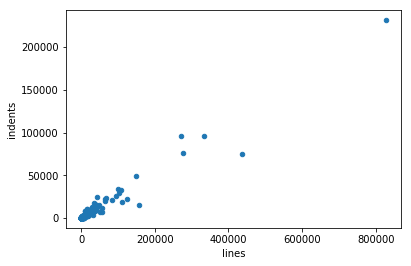

In [24]:
%matplotlib inline
measures_per_component.plot.scatter('lines', 'indents');

In [25]:
measures_per_component.indents.nlargest()

component
drivers:net        231426.0
drivers:staging     96382.0
drivers:scsi        95756.0
drivers:media       76414.0
drivers:gpu         74875.0
Name: indents, dtype: float64

In [27]:
measures_per_component['complexity'] = \
    measures_per_component.indents / measures_per_component.lines
measures_per_component.head()

,lines,indents,complexity
component,,,
Documentation:scheduler,39,12.0,0.307692
Documentation:usb,26,8.0,0.307692
arch:alpha,16690,3722.0,0.223008
arch:arc,7836,1777.0,0.226774
arch:arm,125156,21688.0,0.173288


In [31]:
pd.DataFrame(measures_per_component.complexity.nlargest(10))

,complexity
component,
lib:rbtree.c,1.727273
mm:fadvise.c,1.303030
lib:test_bitmap.c,1.274194
lib:dynamic_queue_limits.c,1.262295
lib:decompress_bunzip2.c,1.229947
lib:lzo,1.048780
fs:coredump.c,1.030651
net:strparser,1.030120
lib:test_bpf.c,0.945170
